# Weighting Scheme Analysis

#### Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import LogFormatterSciNotation


In [14]:
def plot_paper_loss_grad_rate(df, max_epoch=500, alpha=0.1):
    """
    visualization of:
      • Loss evolution (log-scale)
      • Gradient-like evolution (raw + EMA)
      • Rate-of-change evolution (raw + EMA)
    """

    # Limit epochs
    df = df[df["epoch"] <= max_epoch].copy()

    # Colors (tab10 palette)
    colors = {
        "data": "#1f77b4",
        "dt":   "#ff7f0e",
        "pinn": "#2ca02c",
        "ic":   "#d62728",
    }

    #  EMA smoothing helper 
    def ema_nan(series, alpha=0.1):
        smoothed, prev = [], None
        for x in series:
            if np.isnan(x):
                smoothed.append(np.nan)
                continue
            prev = x if prev is None or np.isnan(prev) else alpha * x + (1 - alpha) * prev
            smoothed.append(prev)
        return np.array(smoothed)


    # Gradient magnitudes
    df["d_data_abs"] = df["d_data"].abs().replace(0, np.nan)
    df["d_dt_abs"]   = df["d_dt_norm"].abs().replace(0, np.nan)
    df["d_pinn_abs"] = df["d_pinn_norm"].abs().replace(0, np.nan)
    df["d_ic_abs"]   = df["d_ic"].abs().replace(0, np.nan)

    df["d_data_s"] = ema_nan(df["d_data_abs"], alpha)
    df["d_dt_s"]   = ema_nan(df["d_dt_abs"], alpha)
    df["d_pinn_s"] = ema_nan(df["d_pinn_abs"], alpha)
    df["d_ic_s"]   = ema_nan(df["d_ic_abs"], alpha)


    # Rate of change
    df["R_data"] = (df["d_data_abs"] / df["train_data"]).replace(0, np.nan)
    df["R_dt"]   = (df["d_dt_abs"]   / df["train_dt"]).replace(0, np.nan)
    df["R_pinn"] = (df["d_pinn_abs"] / df["train_pinn"]).replace(0, np.nan)
    df["R_ic"]   = (df["d_ic_abs"]   / df["train_pinn_ic"]).replace(0, np.nan)

    df["R_data_s"] = ema_nan(df["R_data"], alpha)
    df["R_dt_s"]   = ema_nan(df["R_dt"], alpha)
    df["R_pinn_s"] = ema_nan(df["R_pinn"], alpha)
    df["R_ic_s"]   = ema_nan(df["R_ic"], alpha)


    # PAPER STYLE SETTINGS
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 11,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "figure.dpi": 300,
        "savefig.transparent": True,
    })

    fig = plt.figure(figsize=(8, 11))
    gs = GridSpec(6, 1, height_ratios=[5, 1, 5, 1, 5, 1], hspace=0.35)

    ax_loss     = fig.add_subplot(gs[0])
    ax_loss_leg = fig.add_subplot(gs[1])
    ax_grad     = fig.add_subplot(gs[2])
    ax_grad_leg = fig.add_subplot(gs[3])
    ax_rate     = fig.add_subplot(gs[4])
    ax_rate_leg = fig.add_subplot(gs[5])

    for ax in [ax_loss_leg, ax_grad_leg, ax_rate_leg]:
        ax.axis("off")


    # loss evolution
    ax = ax_loss
    ax.plot(df["epoch"], df["train_data"],     color=colors["data"], label="Data loss")
    ax.plot(df["epoch"], df["train_dt"],       color=colors["dt"],   label="dt loss")
    ax.plot(df["epoch"], df["train_pinn"],     color=colors["pinn"], label="PINN loss")
    ax.plot(df["epoch"], df["train_pinn_ic"],  color=colors["ic"],   label="IC loss")

    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(LogFormatterSciNotation())
    ax.set_ylabel("Loss")
    ax.set_title("Loss Evolution")
    ax.grid(True, which="both")

    handles, labels = ax.get_legend_handles_labels()
    ax_loss_leg.legend(handles, labels, ncol=4, loc="center", frameon=False)


    # gradient-like evolution
    ax = ax_grad
    keys = ["data", "dt", "pinn", "ic"]

    for key in keys:
        ax.plot(df["epoch"], df[f"d_{key}_abs"], linestyle=":", alpha=0.45,
                color=colors[key], label=f"{key.upper()} raw")
        ax.plot(df["epoch"], df[f"d_{key}_s"], linewidth=1.8,
                color=colors[key], label=f"{key.upper()} EMA")

    ax.set_yscale("log")
    ax.set_ylabel("Gradient magnitude")
    ax.set_title("Gradient-like Evolution (raw + EMA)")
    ax.grid(True, which="both")

    handles, labels = ax.get_legend_handles_labels()
    ax_grad_leg.legend(handles, labels, ncol=4, loc="center", frameon=False)


    # rate of change
    ax = ax_rate
    for key in keys:
        ax.plot(df["epoch"], df[f"R_{key}"], linestyle=":", alpha=0.45,
                color=colors[key], label=f"{key.upper()} raw")
        ax.plot(df["epoch"], df[f"R_{key}_s"], linewidth=1.8,
                color=colors[key], label=f"{key.upper()} EMA")

    ax.set_yscale("log")
    ax.set_ylabel("Rate of change")
    ax.set_xlabel("Epoch")
    ax.set_title("Rate-of-Change Evolution (raw + EMA)")
    ax.grid(True, which="both")

    handles, labels = ax.get_legend_handles_labels()
    ax_rate_leg.legend(handles, labels, ncol=4, loc="center", frameon=False)

    #plt.tight_layout()
    xmin, xmax = df["epoch"].min(), df["epoch"].max()

    ax_loss.set_xlim(xmin, xmax)
    ax_grad.set_xlim(xmin, xmax)
    ax_rate.set_xlim(xmin, xmax)
    return 

# Scenario Overview (Weighting & Optimizer Experiments)

This project evaluates several training and weighting strategies for PINNs.  
We define a set of **standardized scenario identifiers (S0–S6)** to make comparisons clear and reproducible.

---

## **Scenario List**

| Scenario ID | Description |
|-------------|-------------|
| **S0** | **LBFGS, Static Weights (Baseline)** |
| **S1** | **LBFGS + Loss-Based MA Weighting** |
| **S2a** | **LBFGS (Data-Only Phase → Static Weights after 200 epochs)** |
| **S2b** | **LBFGS (Data-Only Phase → Adaptive Weights from Data Loss after 200 epochs)** |
| **S3** | **LBFGS → Adam at epoch 500, Static Weights** |
| **S4** | **LBFGS → Adam at epoch 500, DN Weighting (Adam only)** |
| **S5** | **LBFGS → Adam at epoch 500, DN Weighting with Warm-Up (start at epoch 1000)** |
| **S6** | **LBFGS → Adam at epoch 500, MA Weighting applied after epoch 1500** |

---

S0: Baseline - LBFGS, Static Weights

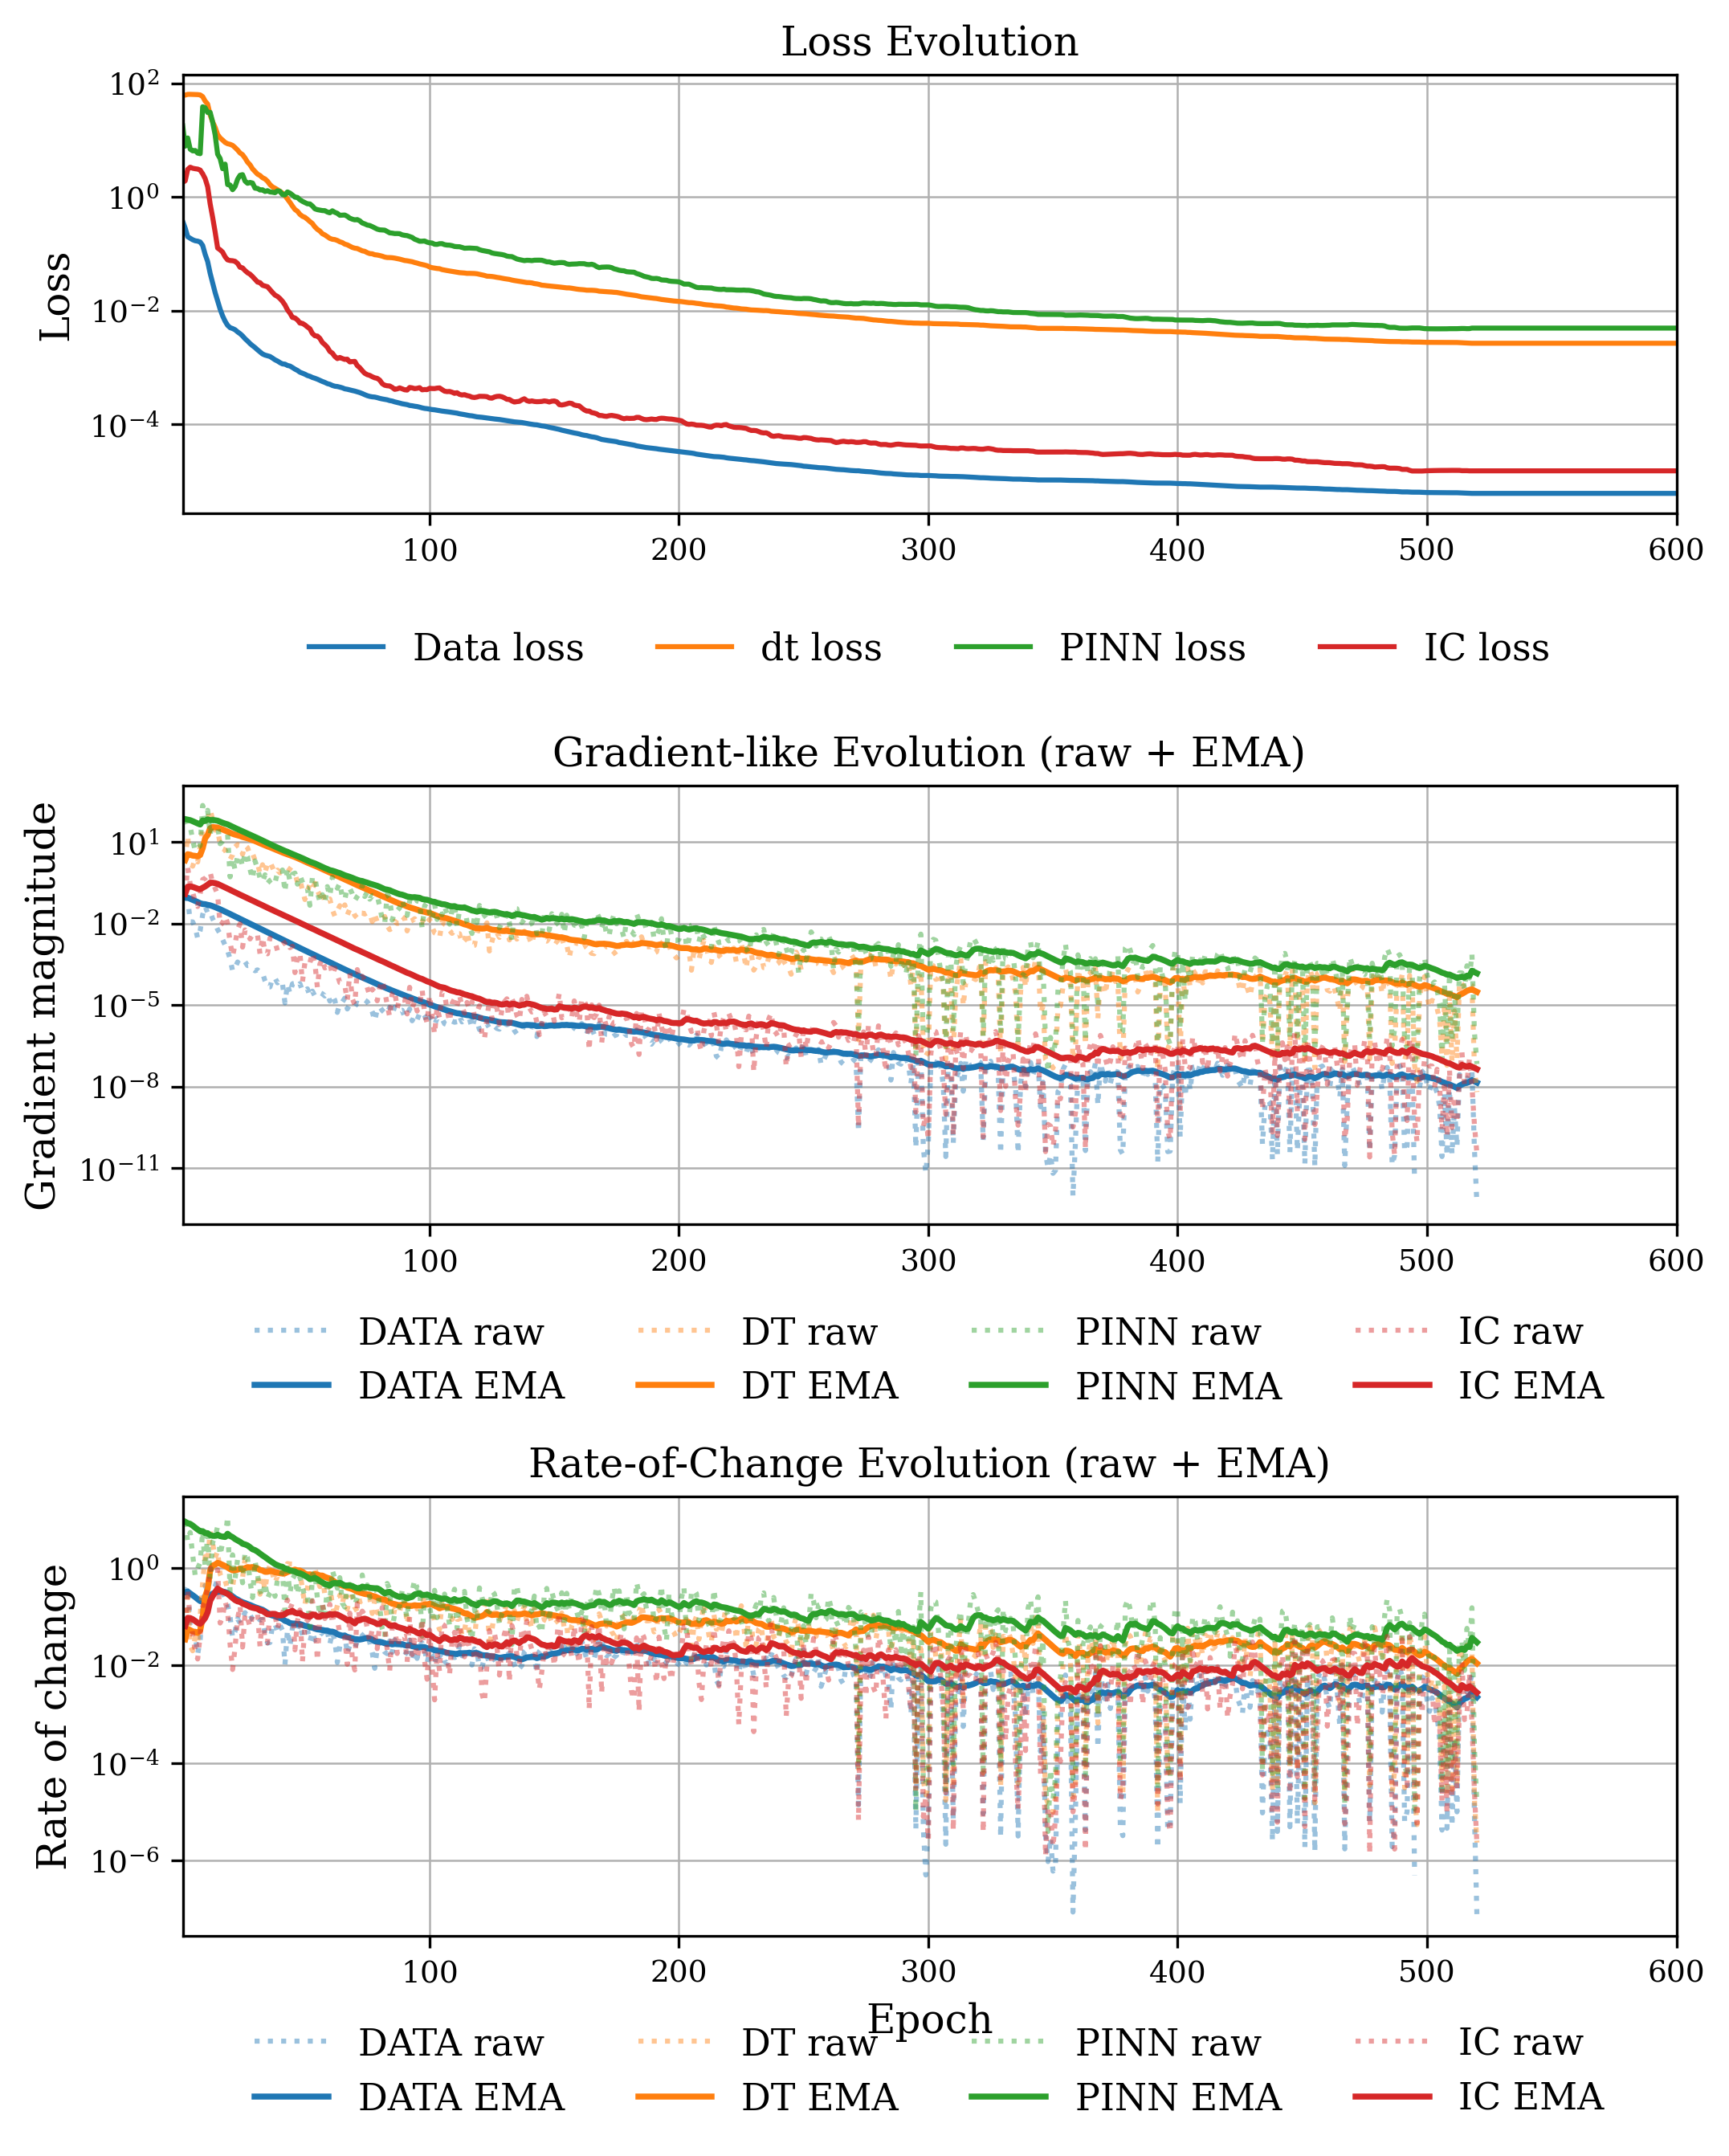

In [15]:
df_static = pd.read_csv("results/2_weighting/training_log_Static_S0.csv")
plot_paper_loss_grad_rate(df_static, max_epoch=600, alpha=0.1)

S1: Loss-based MA weighting, LBFGS

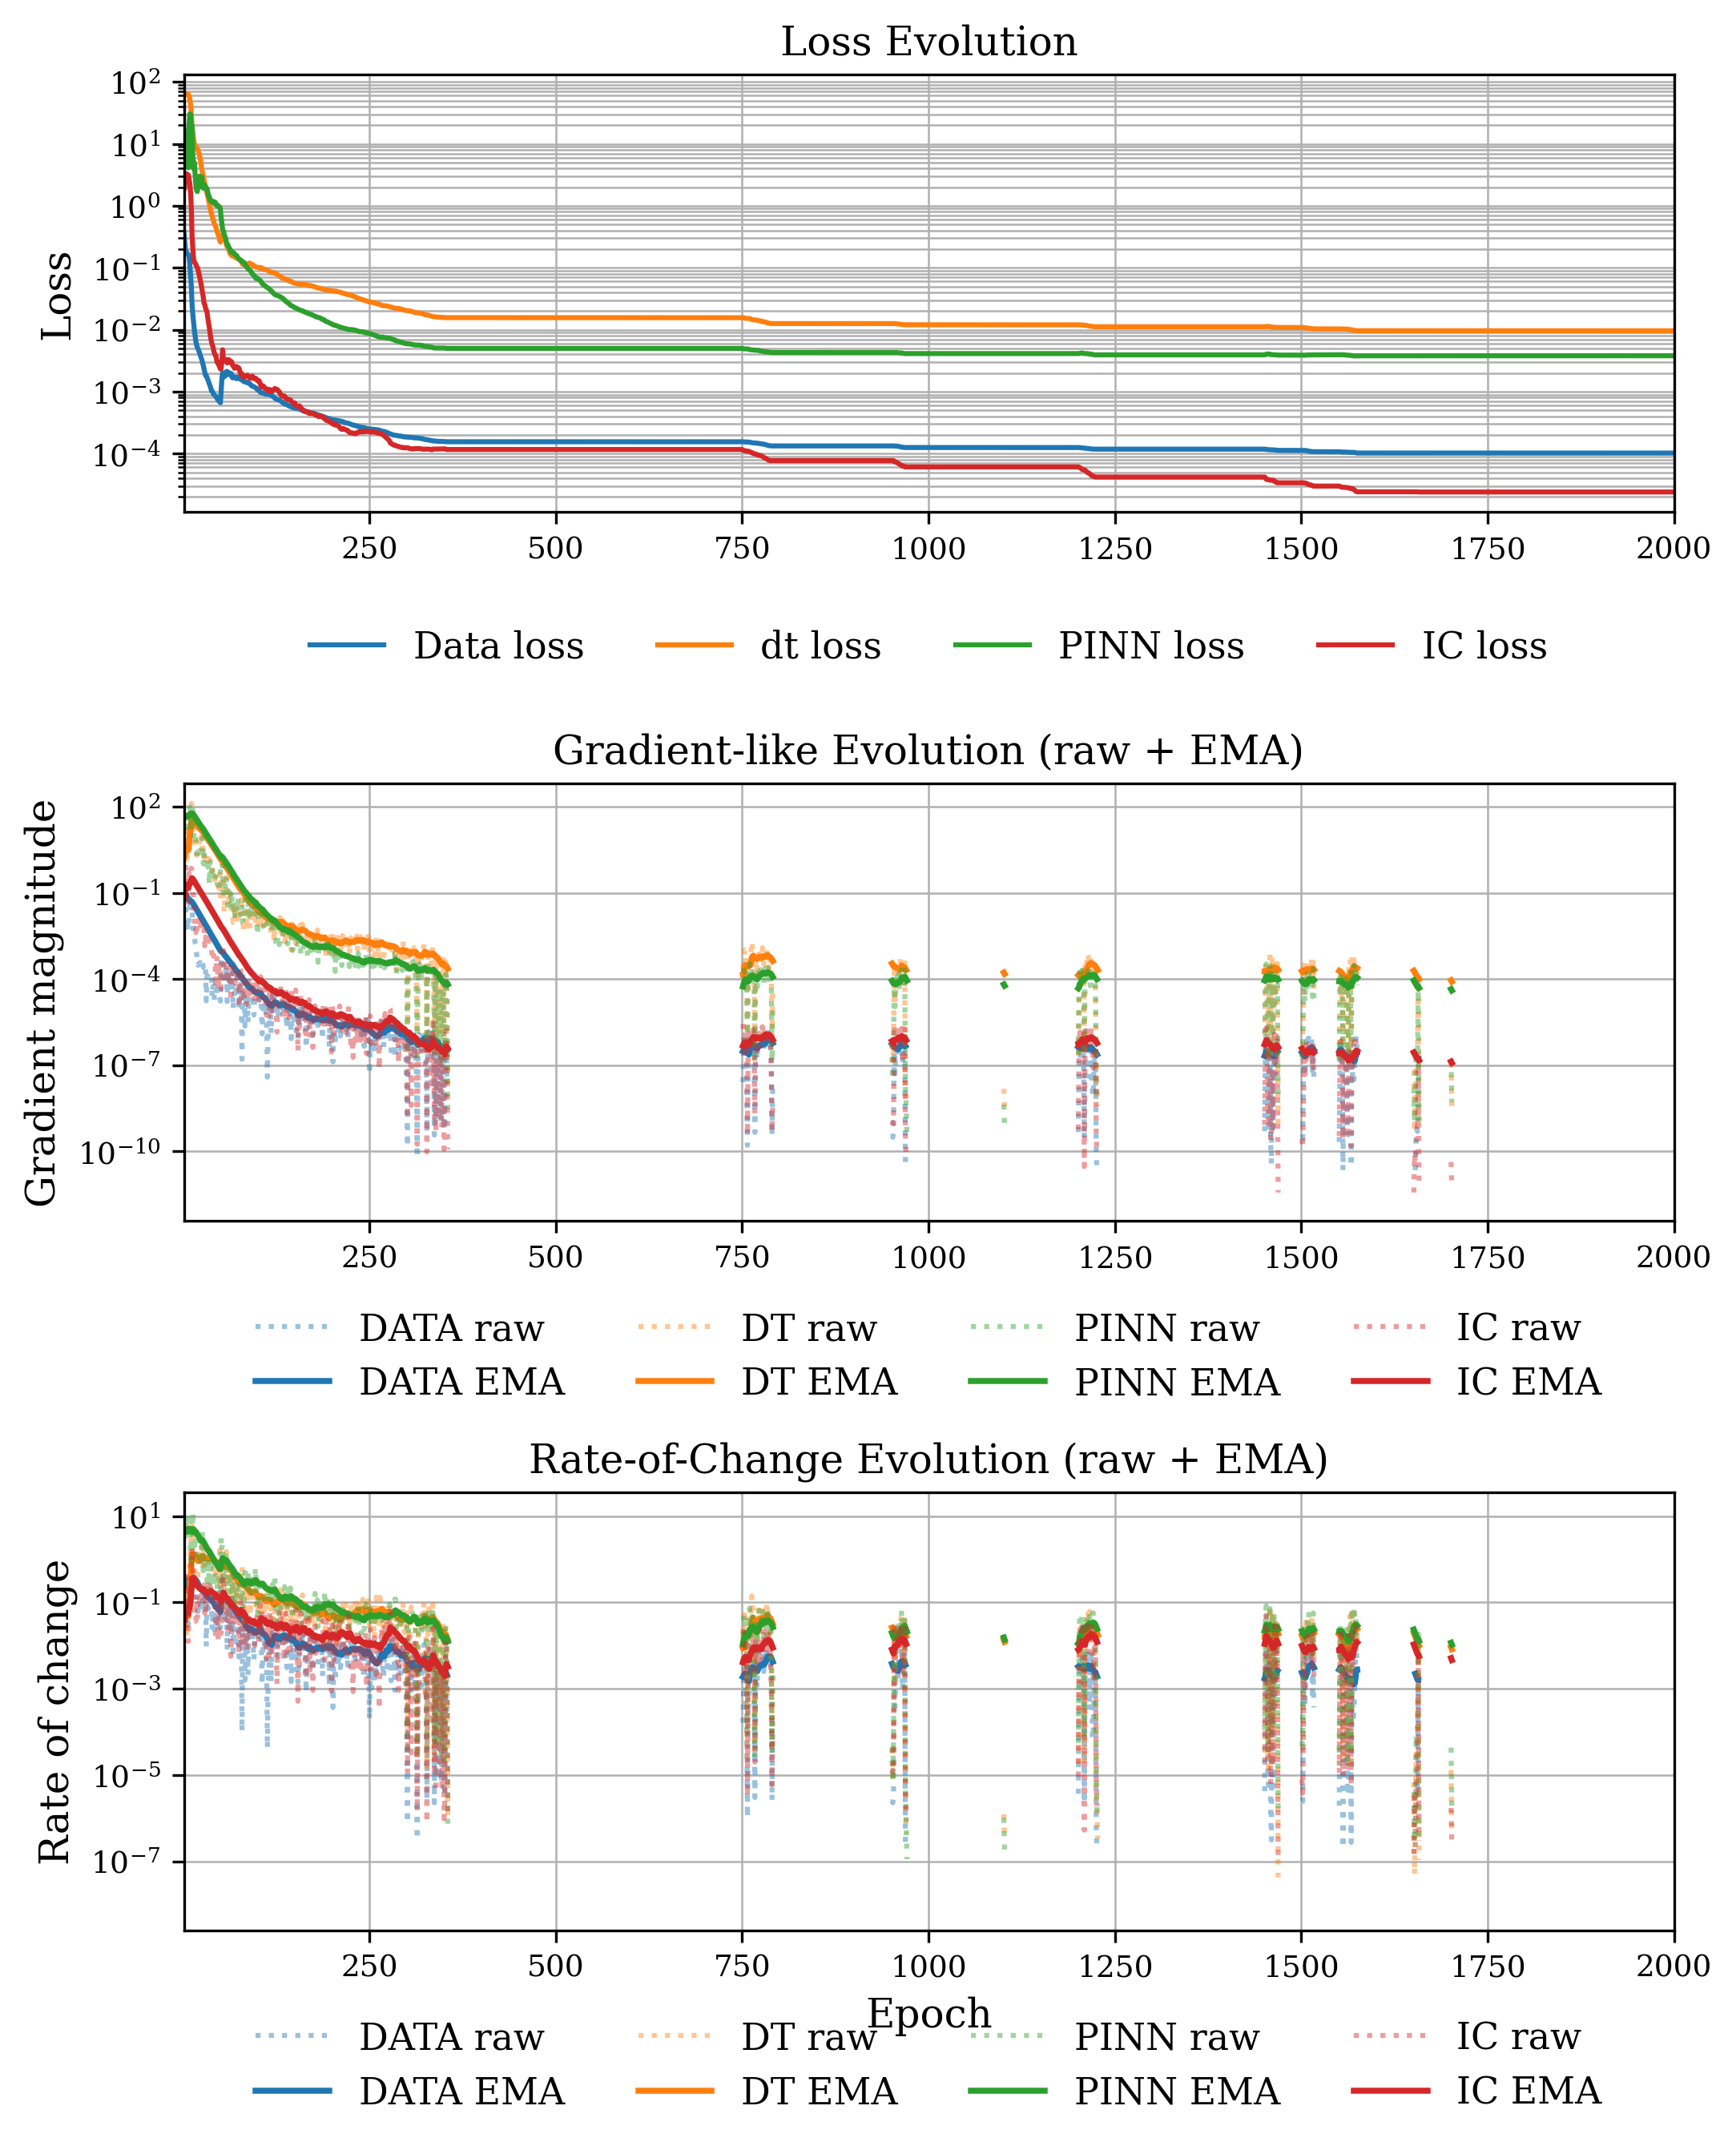

In [16]:
df_MA = pd.read_csv("results/2_weighting/training_log_MA_S1.csv")
plot_paper_loss_grad_rate(df_MA, max_epoch=2000, alpha=0.1)

S2: LBFGS, split training in data only phase and introduce weights after 200 epochs
1) fixed and hard coded
2) adaptive based on the data loss (30% weight respectively for PINN and dt loss)

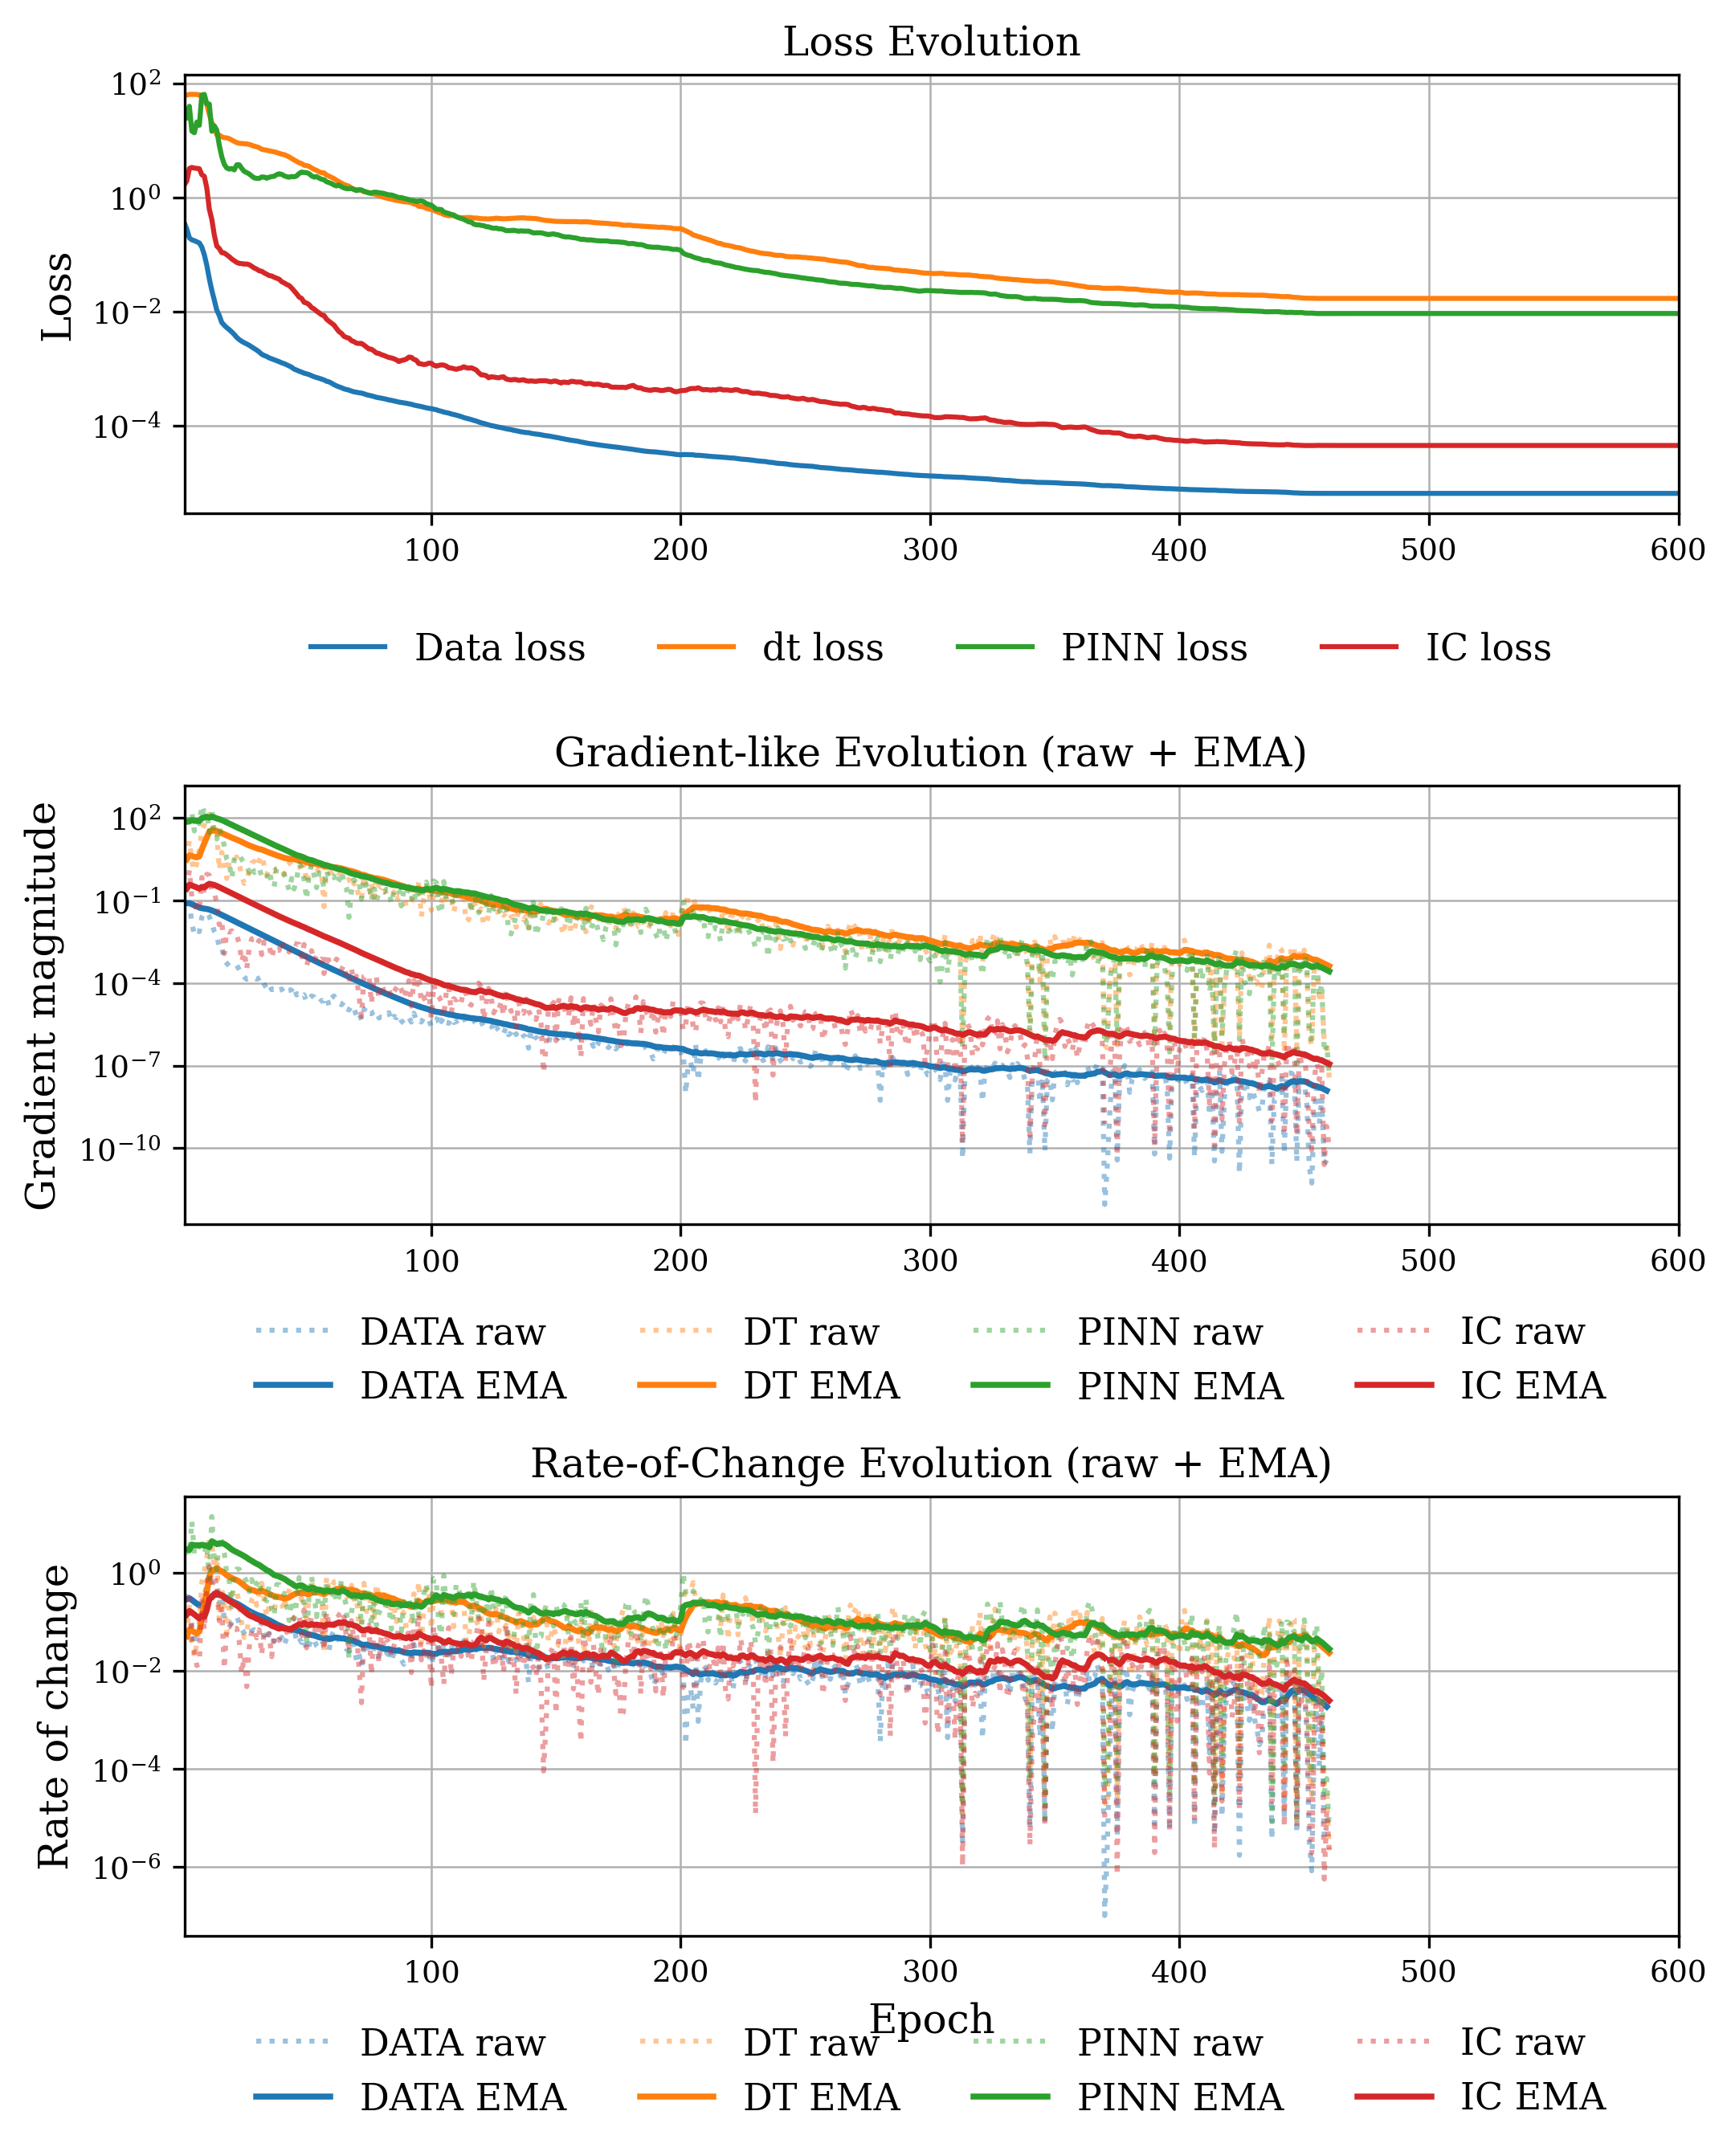

In [17]:
df_static_split_1 = pd.read_csv("results/2_weighting/training_log_Static_S2a.csv")
plot_paper_loss_grad_rate(df_static_split_1, max_epoch=600, alpha=0.1)

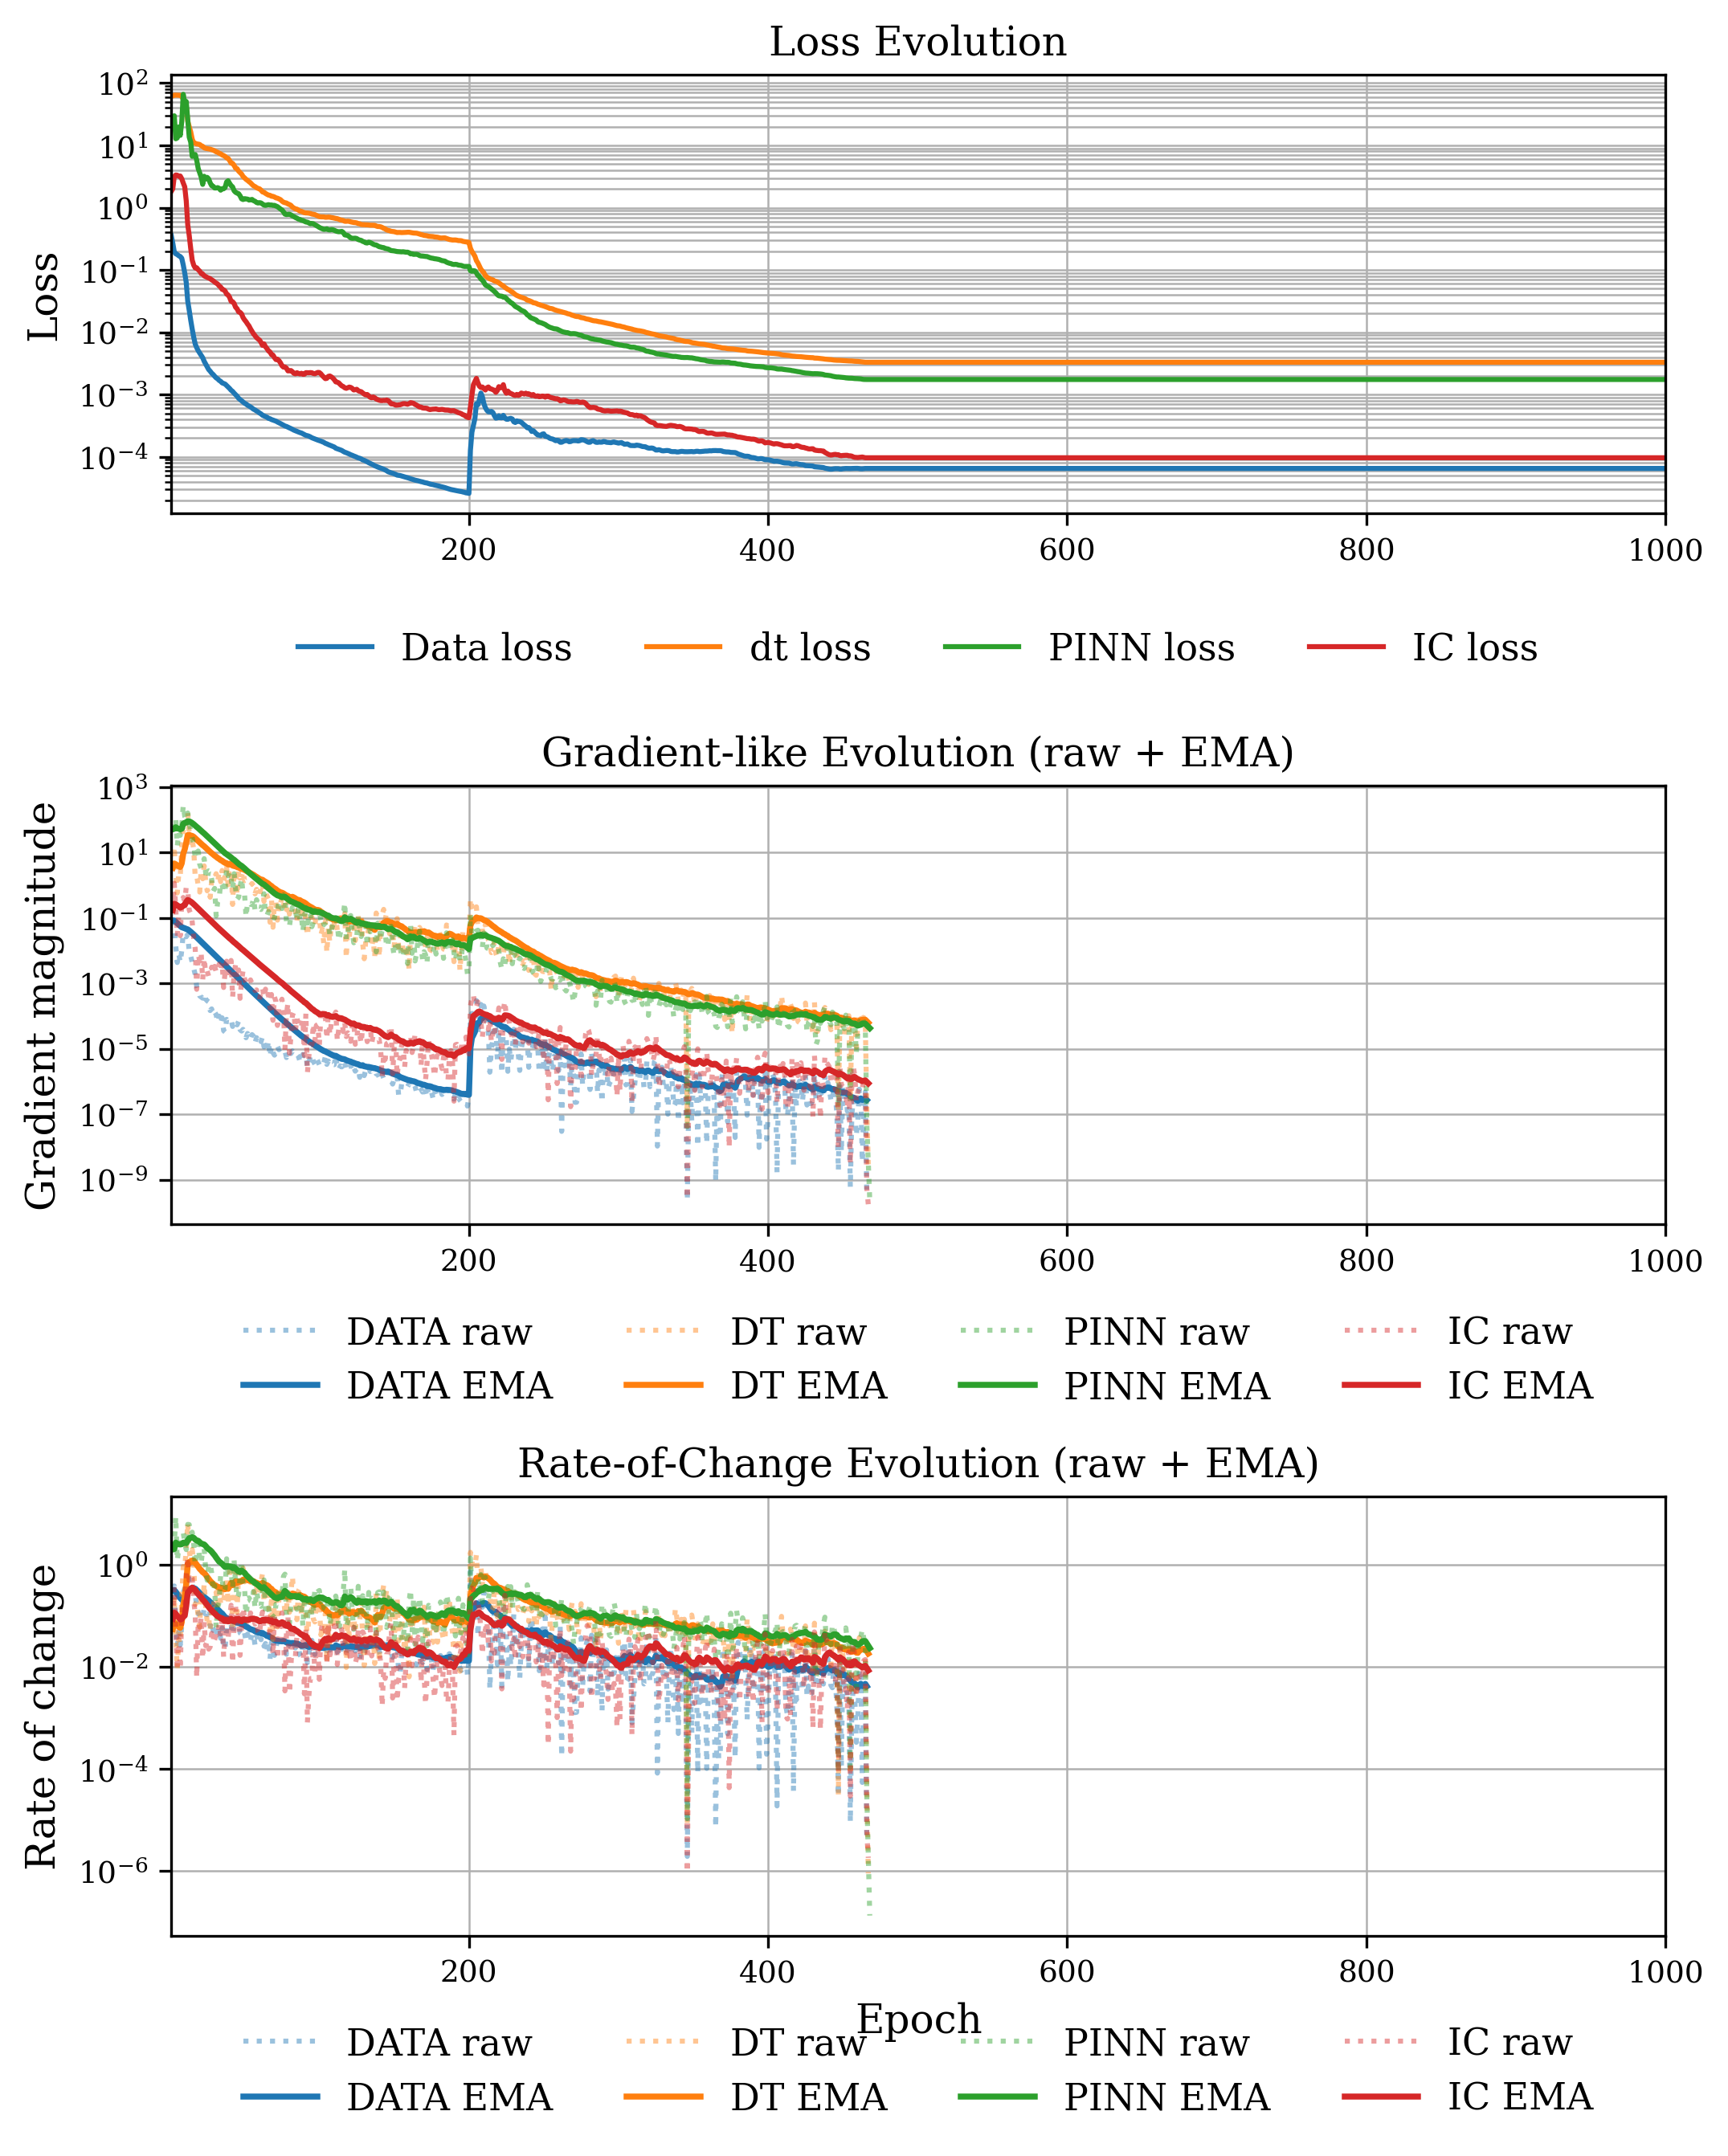

In [18]:
df_static_split_2 = pd.read_csv("results/2_weighting/training_log_Static_S2b.csv")
plot_paper_loss_grad_rate(df_static_split_2, max_epoch=3000, alpha=0.1)

S3: Switching from LBFGS to Adam after 500 epochs, Static Weights for both

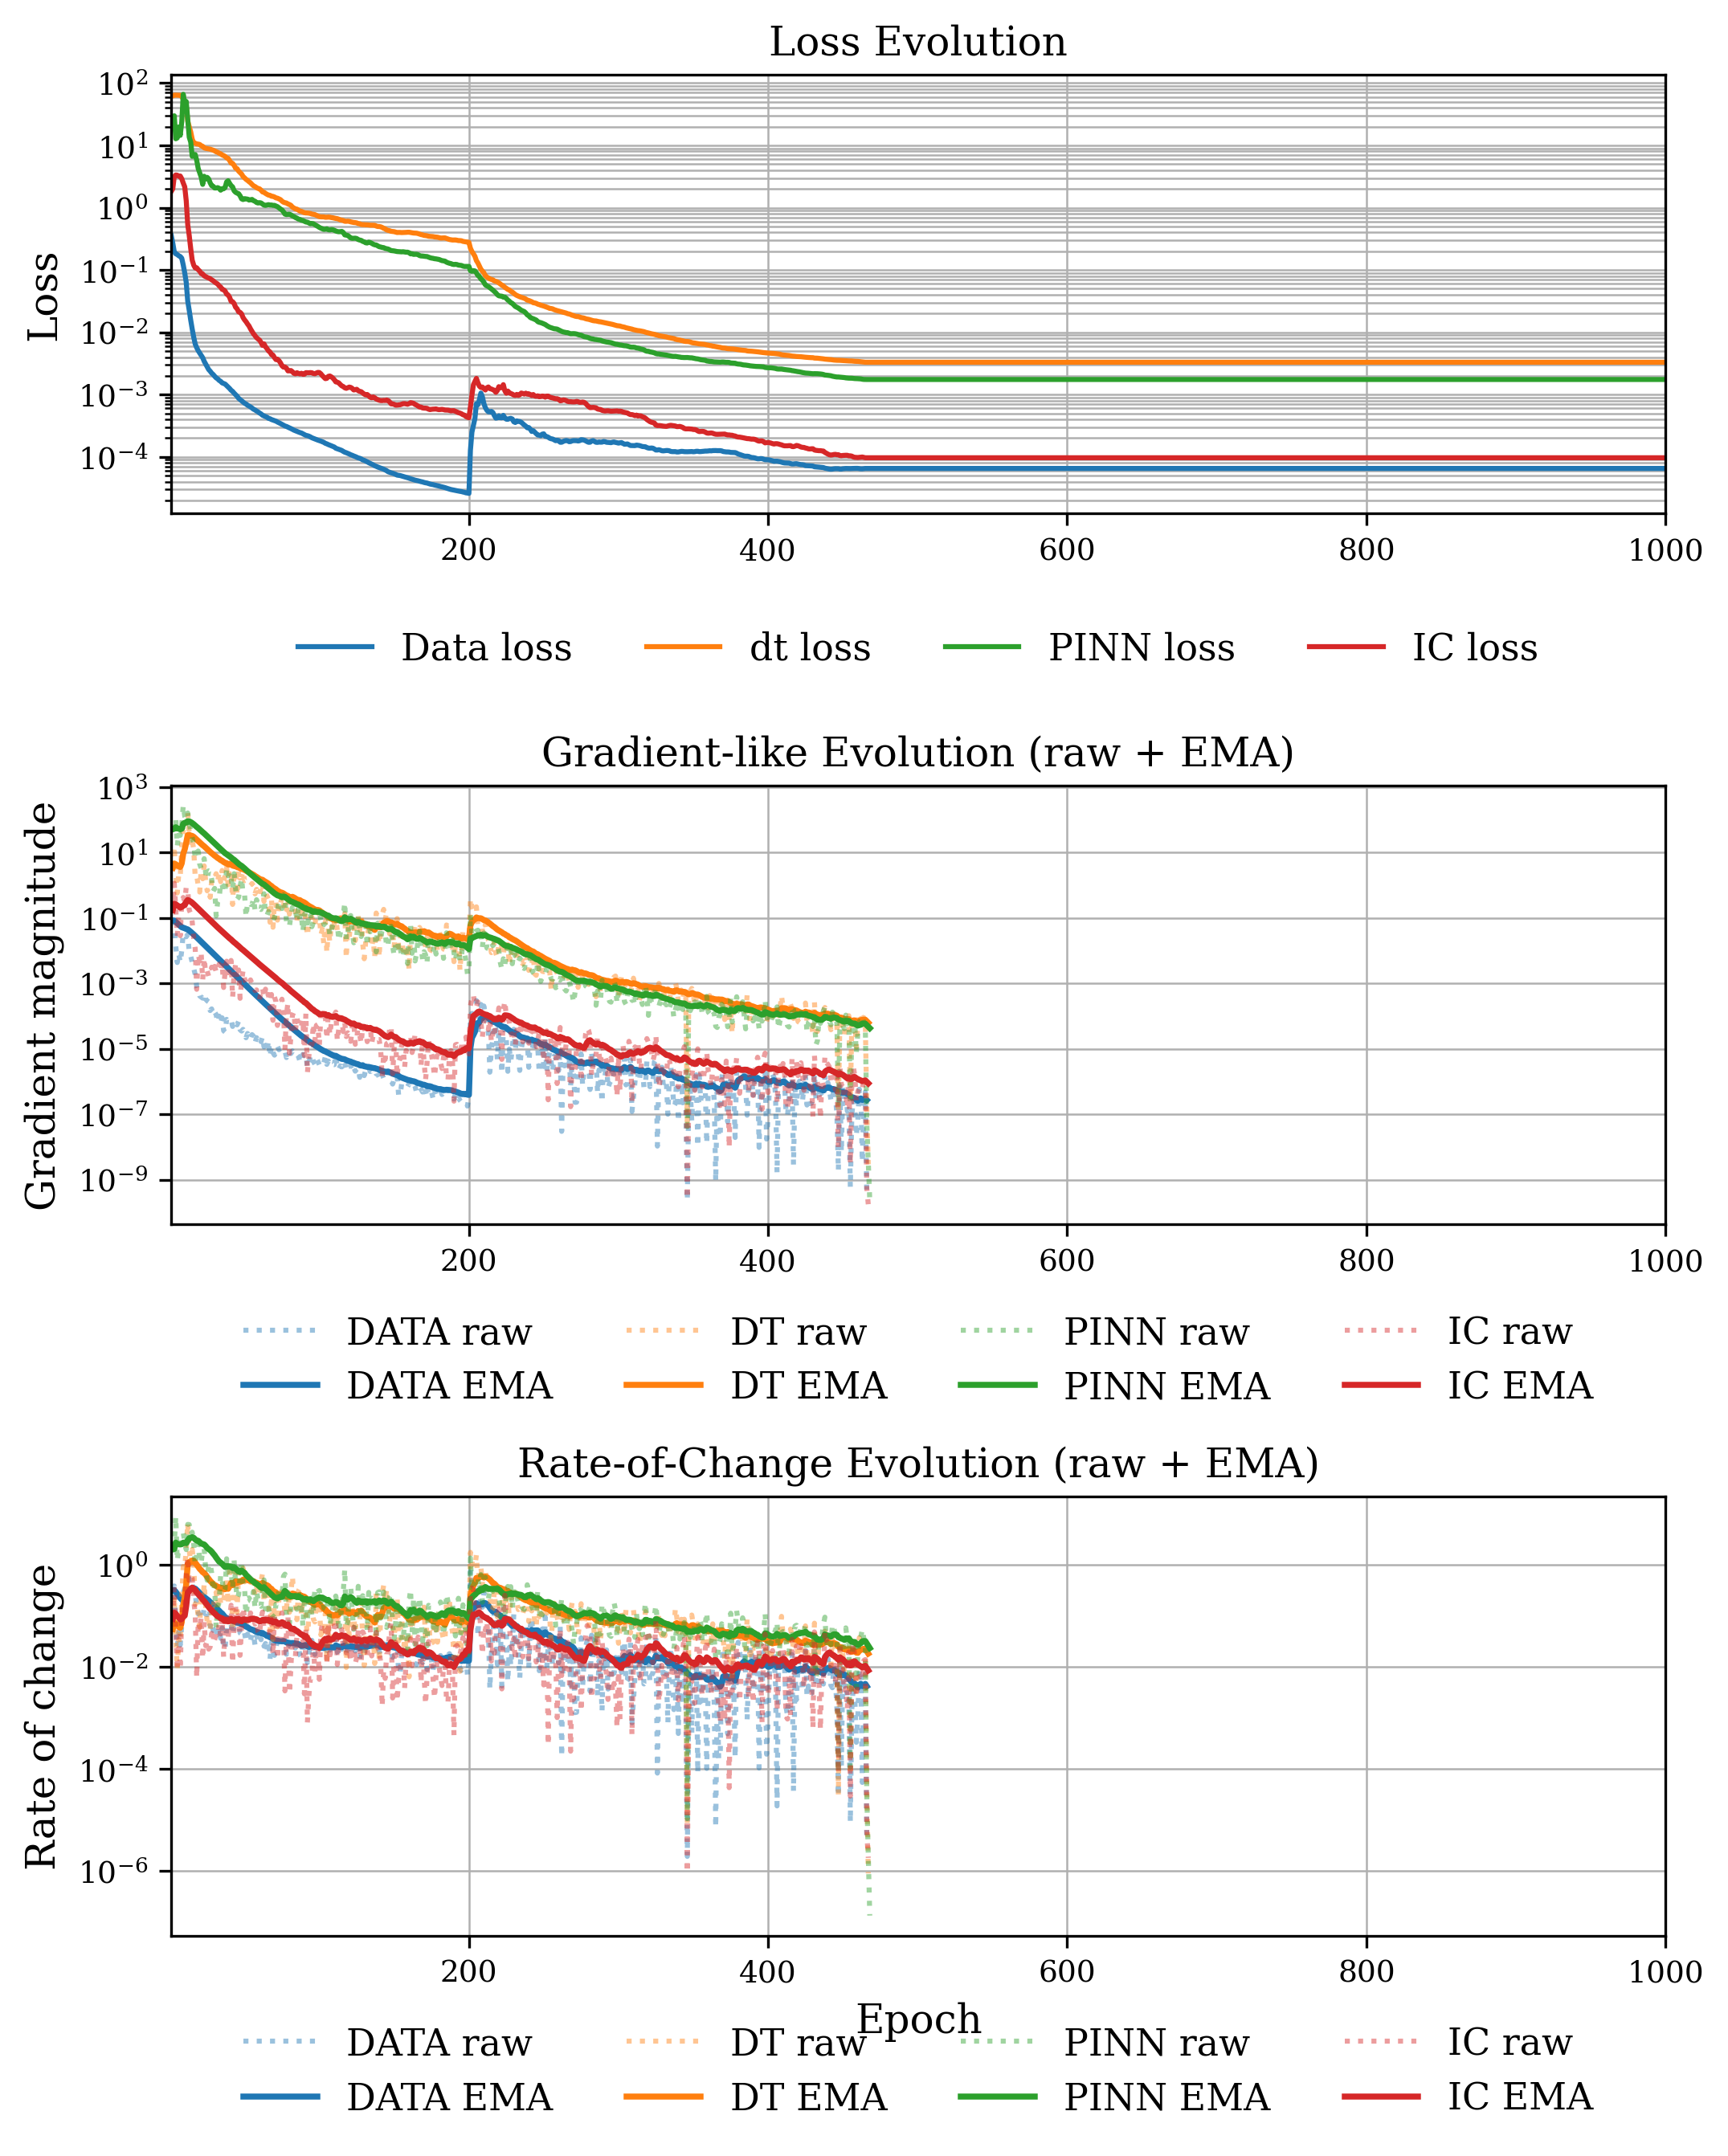

In [19]:
df_static_multi = pd.read_csv("results/2_weighting/training_log_Static_S2b.csv")
plot_paper_loss_grad_rate(df_static_multi, max_epoch=10000, alpha=0.1)

S4: Switching from LBFGS to Adam after 500 epochs, Static weights for LBFGS, DN for ADAM

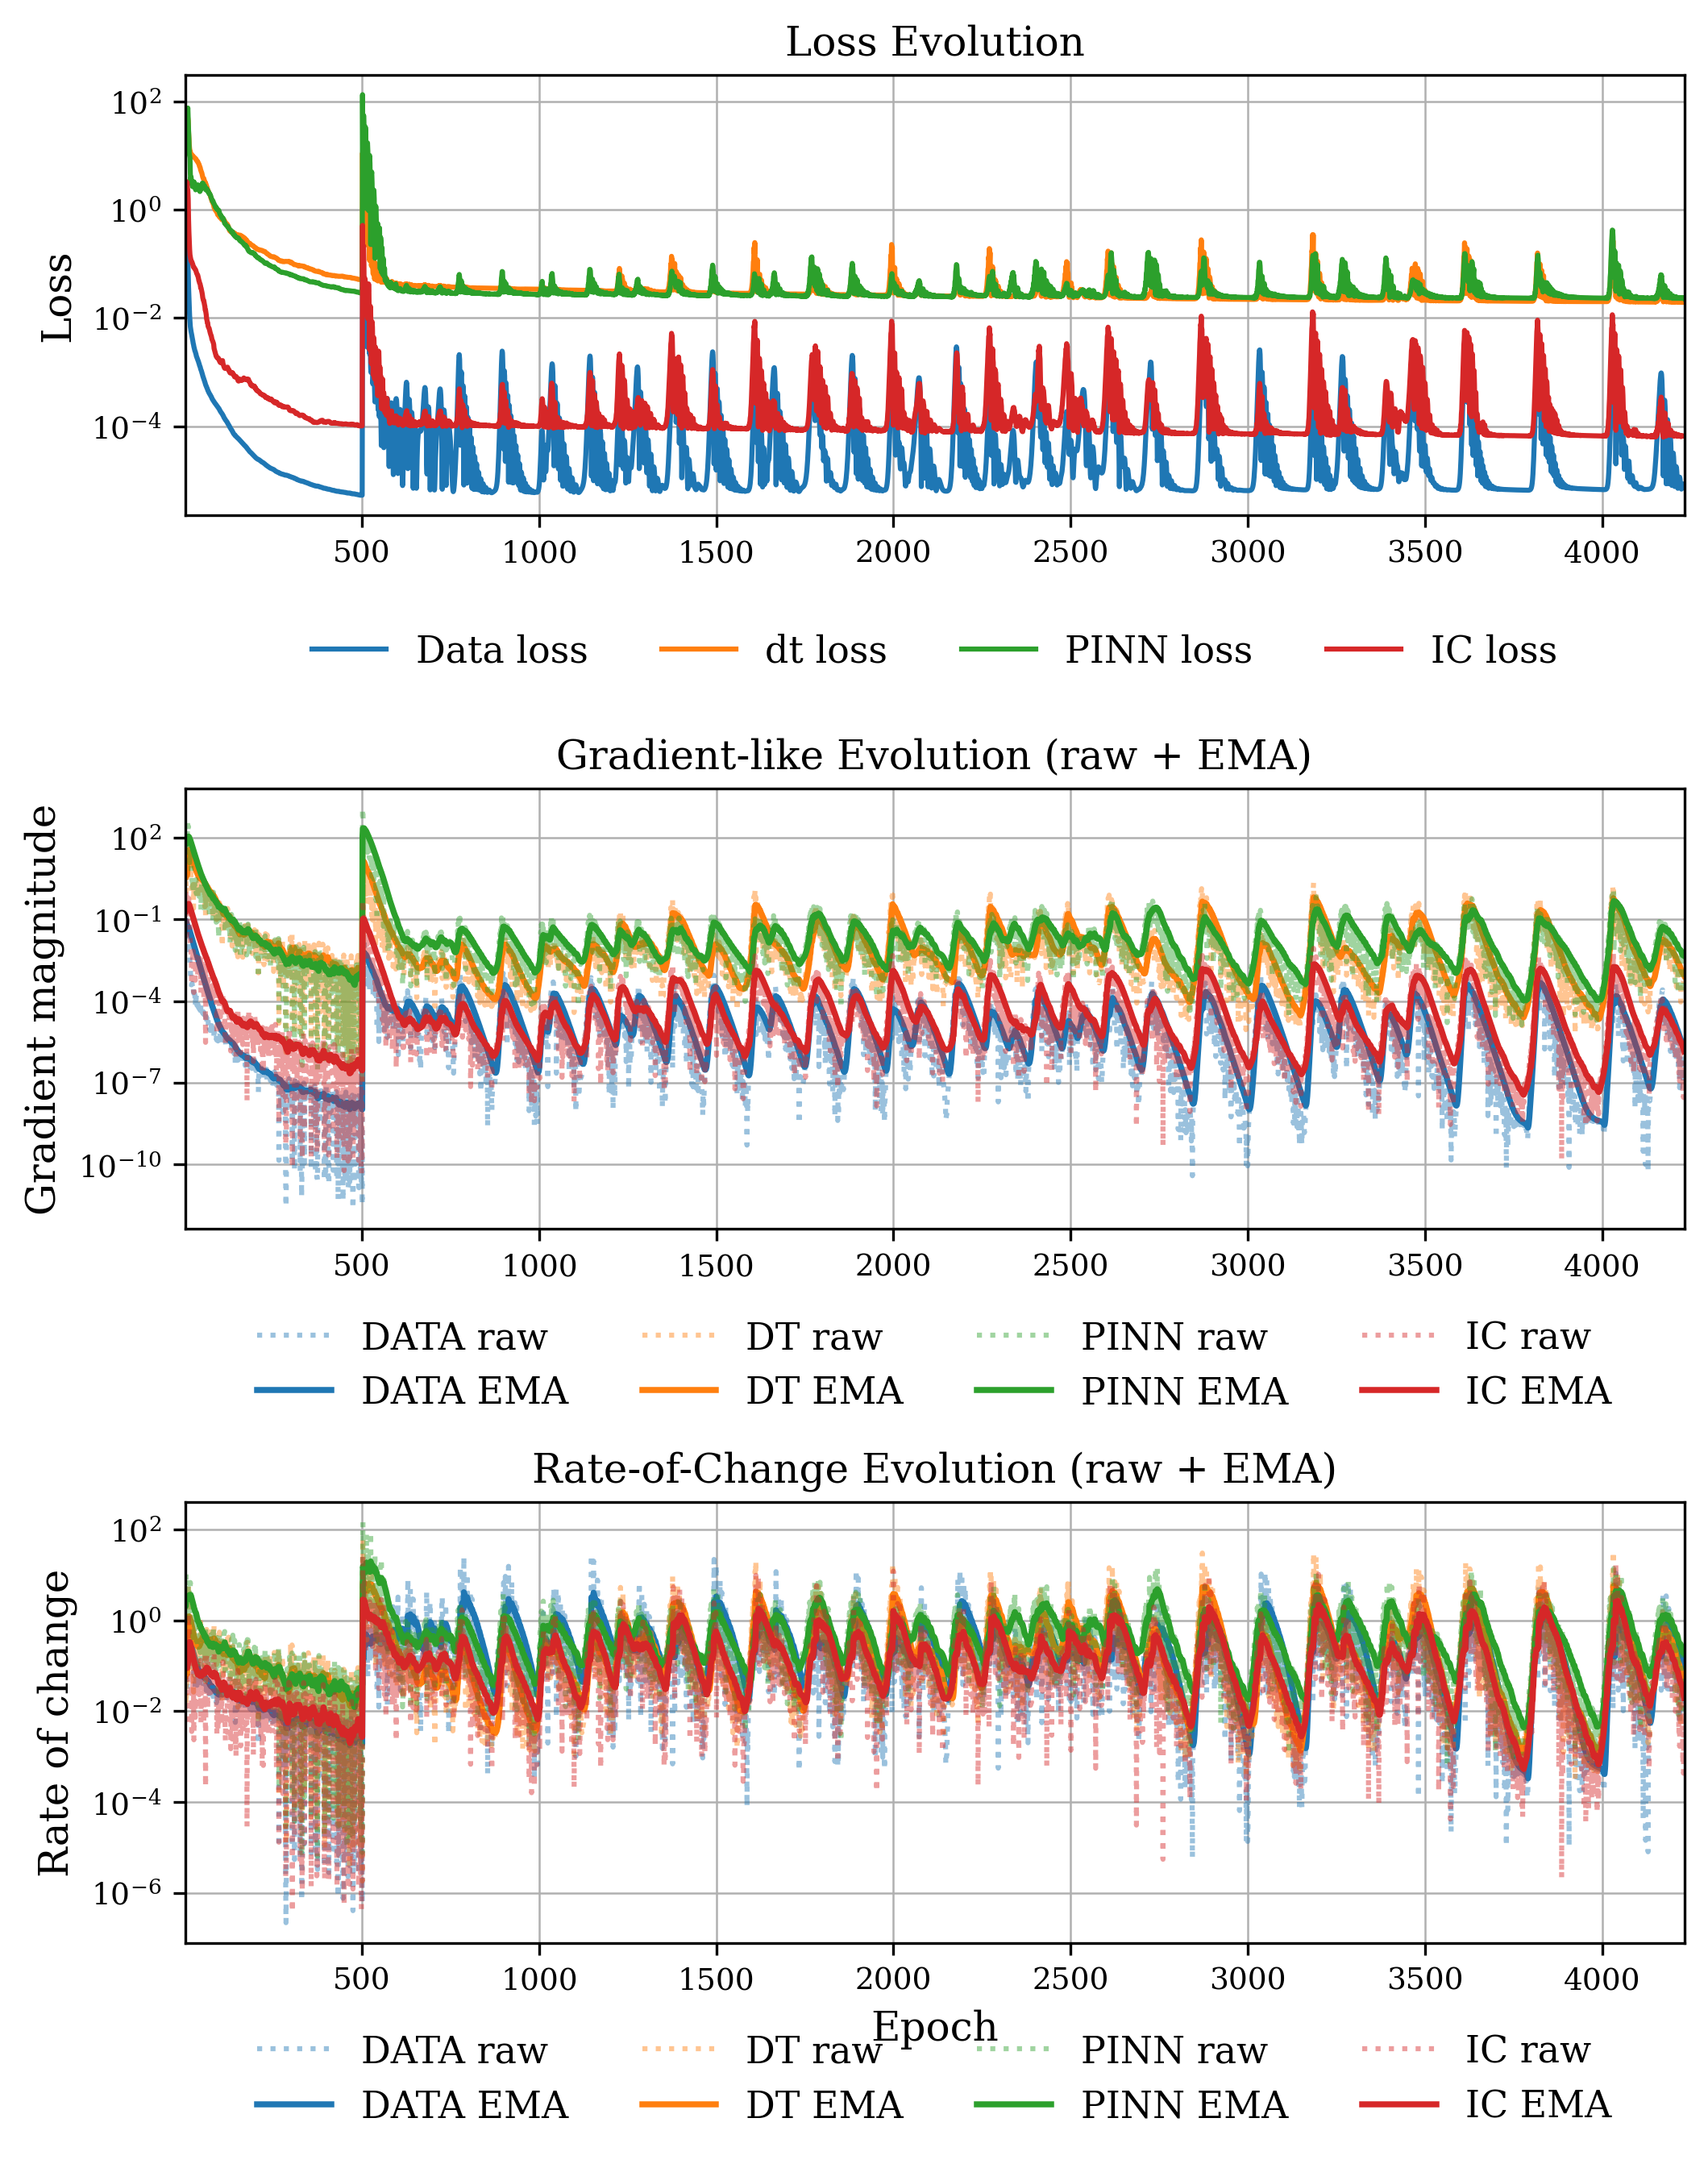

In [20]:
df_static_dn_multi = pd.read_csv("results/2_weighting/training_log_DN_S4.csv")
plot_paper_loss_grad_rate(df_static_dn_multi, max_epoch=10000, alpha=0.1)

S5: Switching from LBFGS to Adam after 500 epochs, Static weights for LBFGS, DN for ADAM - added warm up phase for ADAM, so weighting only starts after 1000 epochs

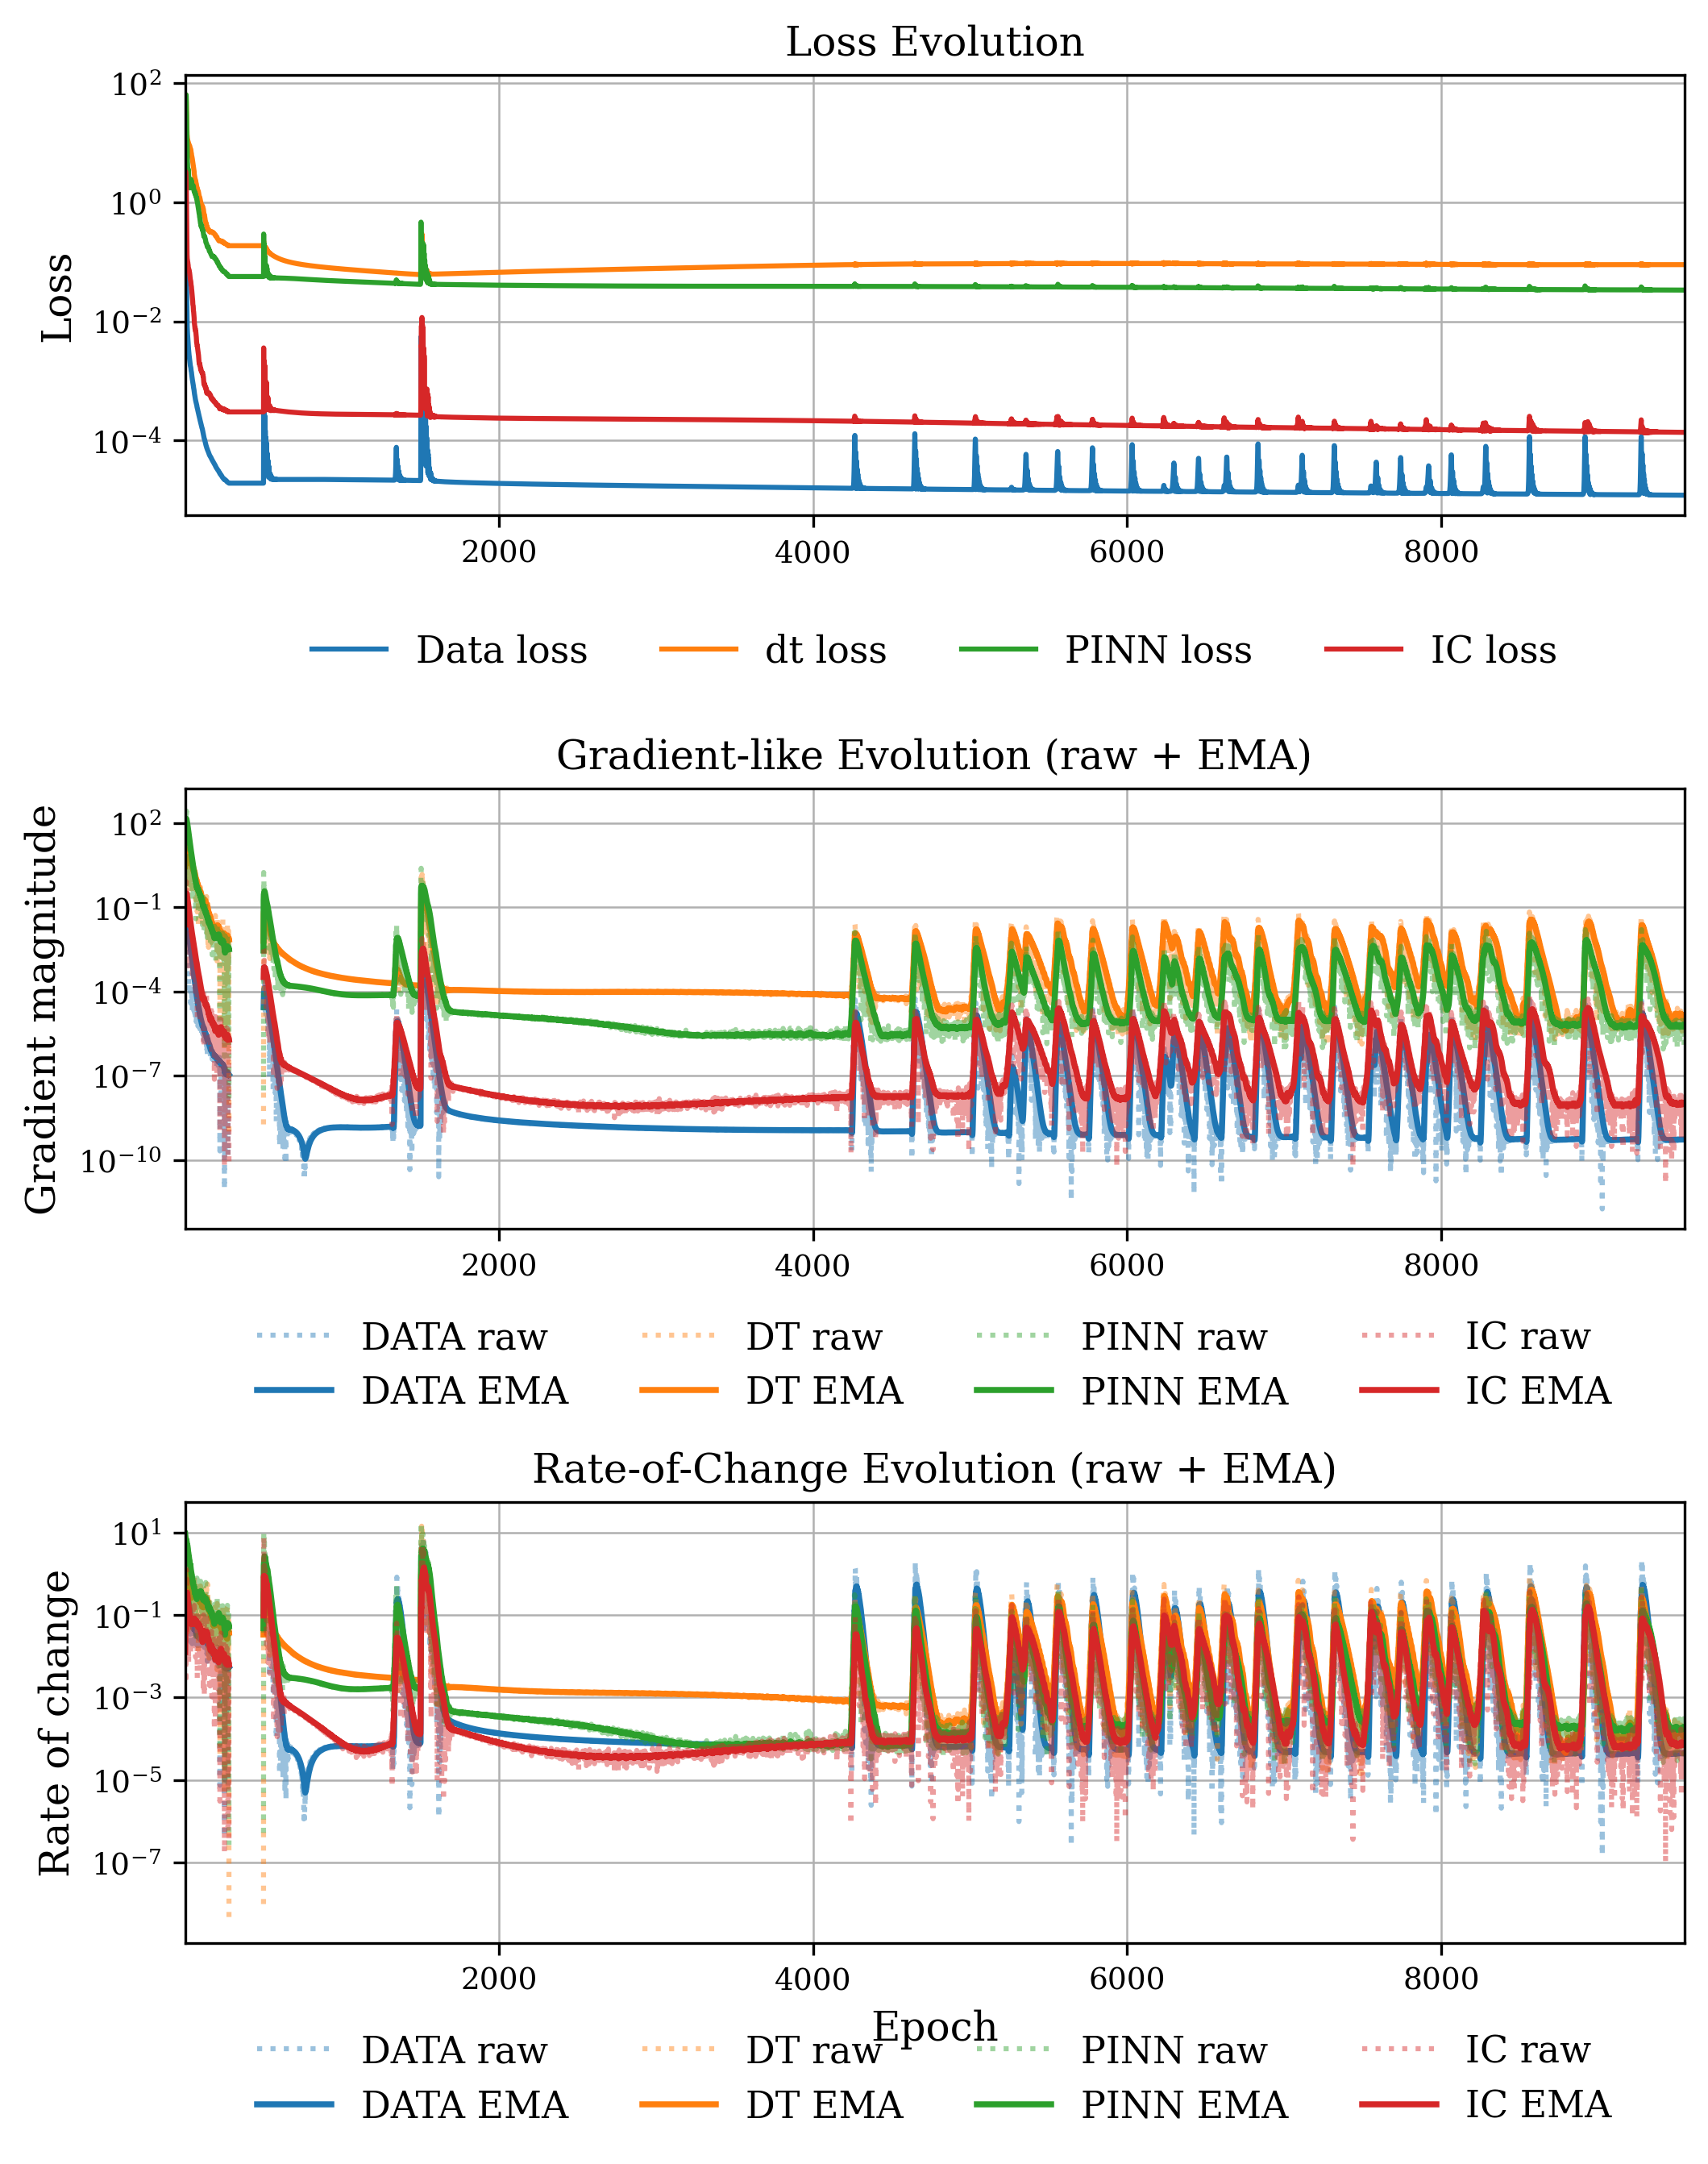

In [21]:
df_dn_multi = pd.read_csv("results/2_weighting/training_log_DN_S5.csv")
plot_paper_loss_grad_rate(df_dn_multi, max_epoch=10000, alpha=0.1)

S6: Switching from LBFGS to Adam after 500 epochs, MA Weighting after 1500 epochs 

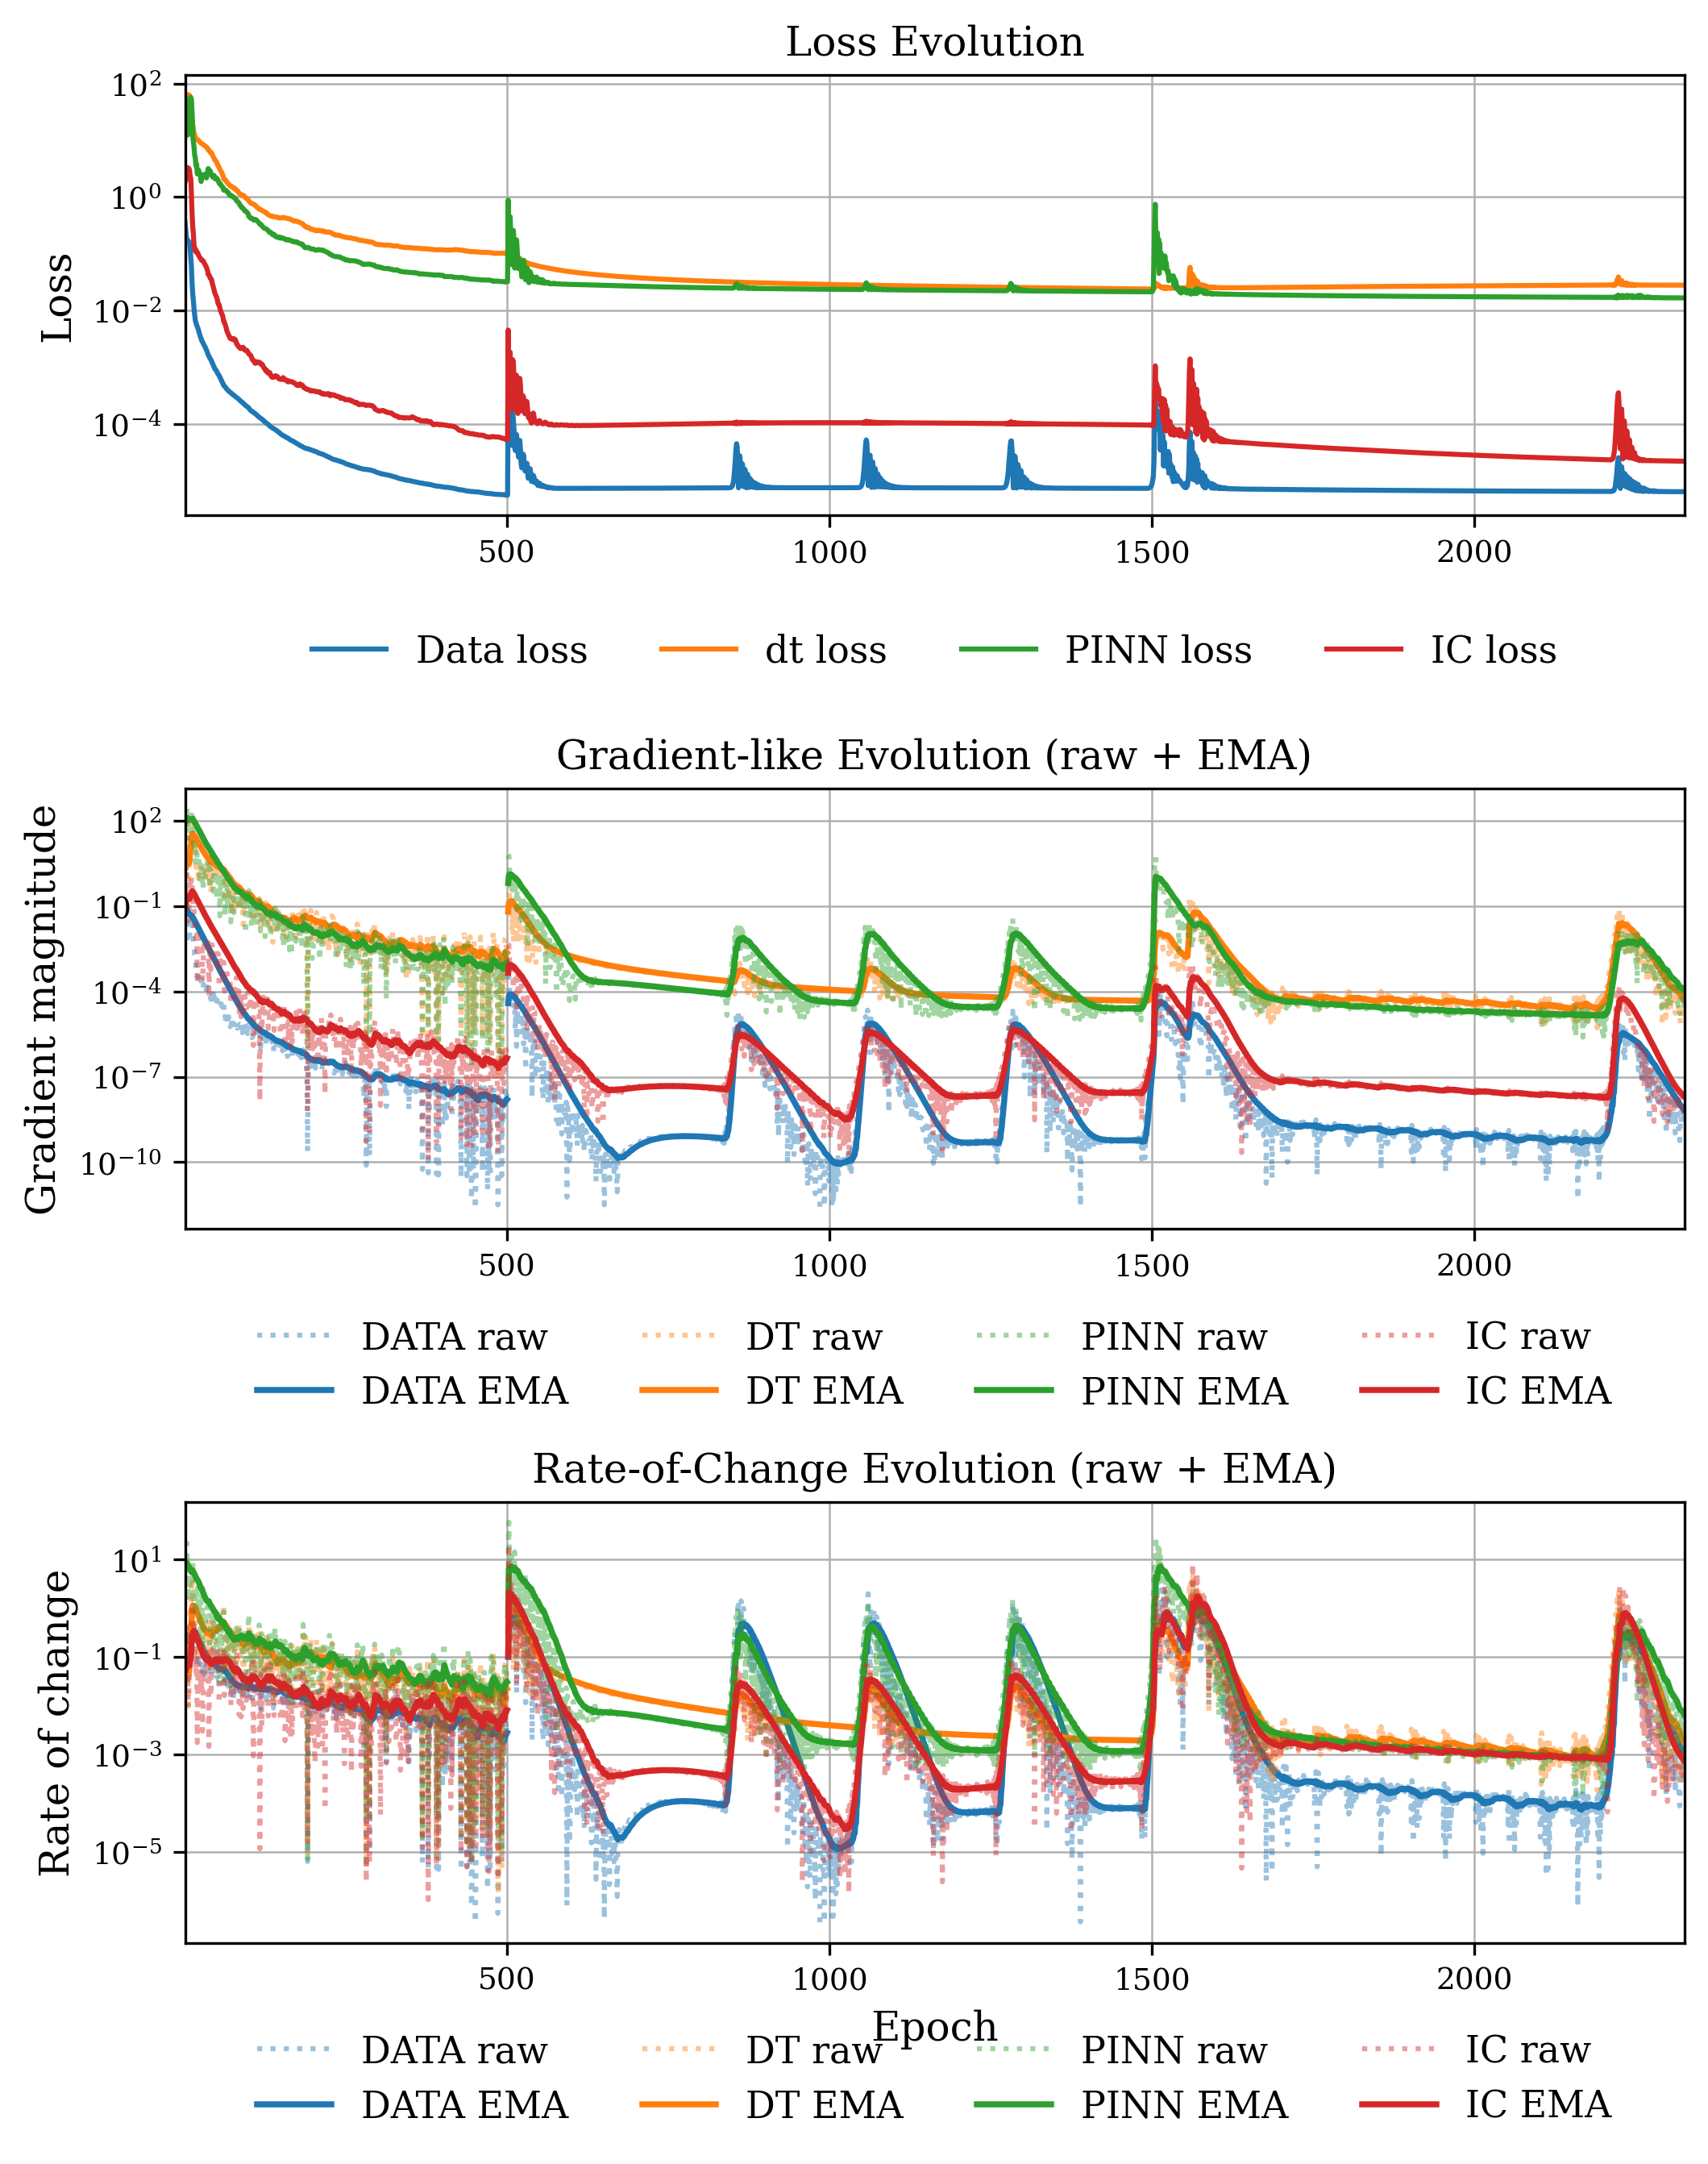

In [22]:
df_ma_multi = pd.read_csv("results/2_weighting/training_log_MA_S6.csv")
plot_paper_loss_grad_rate(df_ma_multi, max_epoch=10000, alpha=0.1)

### Comparison of different validation errors

In [23]:
import pandas as pd

# Dictionary of all your dataframes
dfs = {
    "S0": df_static,
    "S1": df_MA,
    "S2a": df_static_split_1,
    "S2b": df_static_split_2,
    "S3": df_static_multi,
    "S4": df_static_dn_multi,      
    "S5": df_dn_multi,
    "S6": df_ma_multi,
    
}

# Collect results
rows = []

for name, df in dfs.items():
    # Drop NaN rows (avoid issues)
    df_valid = df.dropna(subset=["val_total"])

    # Find best epoch (minimum validation total loss)
    idx = df_valid["val_total"].idxmin()
    best_val = df_valid.loc[idx, "val_total"]
    best_epoch = df_valid.loc[idx, "epoch"]

    rows.append({
        "run": name,
        "best_epoch": int(best_epoch),
        "best_val_total": float(best_val),
    })

# Summary table
summary_table = pd.DataFrame(rows)
#summary_table = summary_table.sort_values("best_val_total")

summary_table

run  best_epoch  best_val_total
0   S0         519        0.002531
1   S1        1701        0.010680
2  S2a         457        0.013835
3  S2b         466        0.003627
4   S3         466        0.003627
5   S4        4231        0.020370
6   S5        1499        0.059256
7   S6        1502        0.021668